In [6]:
from dotenv import load_dotenv
load_dotenv('secret.env')

True

In [7]:
from typing import TypedDict, List
from pydantic import BaseModel, Field

from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import MarkdownifyTransformer
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph, END

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

def get_chat():
    chat = ChatGoogleGenerativeAI(model='gemini-2.0-flash-001')
    return chat

In [4]:
class State(TypedDict):
    url: str
    planning_steps: List[str]
    title: str
    document: str
    figures: List[str]
    tables: List[str]
    drafts: List[str]
    final_doc: str

In [5]:
def get_document_node(state: State):
    url = state.get('url')
    loader = AsyncHtmlLoader(url)
    docs = loader.load()
    
    md = MarkdownifyTransformer()
    converted_docs = md.transform_documents(docs)
    
    title = converted_docs[0].metadata['title']
    document = converted_docs[0].page_content

    return State(title=title, document=document)

In [6]:
plan_instruction = [
    "You are a helpful assistant in writing technical documentation. You know how to summary the arguments in a document and organize them into the following structure: introduction / body / conclusion, claims and evidence, cause and effect, compare and contrast, problem and solution.",
    "The document is as follows:",
    "{document}",
    "Please break it down in the following format, with each subtask taking up one line:",
    "Paragraph 1 - Main Point: [Describe the main point of the paragraph, in detail], Word Count: [Word count requirement, e.g., 800 words]",
    "Paragraph 2 - Main Point: [Describe the main point of the paragraph, in detail], Word Count: [word count requirement, e.g. 1500 words]",
    "...",
    "Make sure that each subtask is clear and specific, and that all subtasks cover the entire content of the writing instruction.",
    "Do not split the subtasks too finely; each subtask's paragraph should be no less than 200 words and no more than 1000 words.",
    "Do not output any other content.",
    "As this is an ongoing work, omit open-ended conclusions or other rheotorical hooks.",
    "Write in Korean."
]

In [7]:
def plan_node(state: State):
    print("##### Plan ######")
    document = state.get('document')
    
    planner_prompt = ChatPromptTemplate([('human', plan_instruction)])
    chat = get_chat()

    planner = planner_prompt | chat
    response = planner.invoke({"document": document})
    plan = response.content.strip().replace('\n\n','\n')
    planning_steps = plan.split('\n')

    return State(planning_steps=planning_steps)

In [8]:
extract_materials_instruction = [
    "You should extract the figures and tables from the document.",
    "document:",
    "{document}",
    "Use xml syntax to format your output:",
    "- Use <img src=url> to insert an image. Provide a caption for the image with the <caption> tag for accessibility.",
    "- Use <table> for alignment. Keep tables concise and structured.",
    "Provide the figures with <figures> tag and provide the tables with <tables> tag. If there no any images or tables, include empty figures or tables tag.",
    "Do not output any other content."
]

In [9]:
def extract_materials(state: State):
    print("##### Extract Materials #####")
    document = state.get('document')

    materials_prompt = ChatPromptTemplate([('human', extract_materials_instruction)])
    chat = get_chat()
    
    extracted_materials = materials_prompt | chat
    response = extracted_materials.invoke({"document": document})
    materials = response.content

    figure_materials = materials[materials.find('<figures>')+9:materials.find('</figures>')].split('\n\n')
    table_materials = materials[materials.find('<tables>')+8:materials.find('</tables>')].split('\n\n')

    figures, tables = [], []
    for figure in figure_materials:
        figures.append(figure.strip())

    for table in table_materials:
        tables.append(table.strip())
    
    return State(figures=figures, tables=tables)

In [ ]:
write_instruction = [
    "You are an excellent technical writing assistant. I will give you an original document, my planned writing steps and materials with figures and tables. I will also provide you with the text I have already written. Please help me continue writing the next paragraph based on the document, writing steps, figures, tables, and the already written text.",
    "If your documentation mentions images, insert them in your draft.",
    "document:",
    "{document}",
    "Writing steps:",
    "{plan}",
    "Already written text:",
    "{text}",
    "Figures:",
    "{figures}",
    "Tables:",
    "{tables}",
    "Please integrate the original document, writing steps, and the already written text, figures, tables, and now continue writing {STEP}.",
    "For structured posts, you can add a small subtitle at the beginning.",
    "Remember to only output the paragraph you write, without repeating the already written text.",
    "Use markdown syntax to format your output:",
    "- Headings: # for main, ## for sections, ### for subsections, etc.",
    "- Lists: * or - for bulleted, 1. 2. 3. for numbered",
    "- Images: ![](image url)\n_(caption text)_: to insert an image. Do not use xml tags and do not insert any description.",
    "- Tables: | Column 1 | Column 2 | Column 3 | with |---|---|---| as separators; Ensure proper alignment for readability.",
    "- Dot not repeat yourself",
    "Provide the final answer with <result> tag.",
    "Write in Korean."
]

In [11]:
def execute_node(state: State):
    print("##### Write (execute) #####")
    document = state.get('document')
    planning_steps = state.get('planning_steps')
    figures = state.get('figures')
    tables = state.get('tables')

    write_prompt = ChatPromptTemplate([('human', write_instruction)])
    text = ""
    drafts = []
    for step in planning_steps:
        chat = get_chat()
        write_chain = write_prompt | chat

        result = write_chain.invoke({
            "document": document,
            "plan": planning_steps,
            "text": text,
            "STEP": step,
            "figures": figures,
            "tables": tables
        })
        output = result.content

        draft = output[output.find('<result>')+8:len(output)-9]

        print(f"--> step:{step}")
        print(f"--> {draft}")

        drafts.append(draft)
        text += draft + '\n\n'
    
    return State(drafts=drafts)

In [12]:
class ReflectionState(TypedDict):
    draft: str
    reflection: List[str]
    search_queries: List[str]
    revised_draft: str
    revision_number: int

In [13]:
class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing")
    advisable: str = Field(description="Critique of what is helpful for better writing")
    superfluous: str = Field(description="Critique of what is superfluous")

class Research(BaseModel):
    """Provide reflection and then follow up with search queries to improve the writing."""

    reflection: Reflection = Field(description="Your reflection on the initial writing for summary.")
    search_queries: List[str] = Field(description="1-3 search queries for researching improvements to address the critique of your current writing.")

def reflect_node(state: ReflectionState, config):
    print('##### Reflect #####')
    draft = state.get('draft')
    on_search = config['configurable'].get('on_search',True)

    reflection = []
    search_queries = []
    for _ in range(2):
        chat = get_chat()
        structured_llm = chat.with_structured_output(Research, include_raw=True)

        info = structured_llm.invoke(draft)
        if not info['parsed'] == None:
            parsed_info = info['parsed']
            reflection = [parsed_info.reflection.missing, parsed_info.reflection.advisable]
            if on_search:
                search_queries = parsed_info.search_queries
            break

    revision_number = state.get('revision_number') if state.get('revision_number') is not None else 1
    return ReflectionState(revision_number=revision_number, search_queries=search_queries, reflection=reflection)

In [14]:
revise_instruction = [
    "You are an excellent technical writing assistant. Your objective is publishing summary of document to tech blog for other engineer.",
    "Revise this draft using the critique and additional information, and consider readability while keeping it structured format.",
    "For readability, if needed, you can add a subtitle at the beginning.",
    "If you're using a table, make sure that each row has the same number of columns.",
    "Don't use the same image in duplicate.",
    "Don't put any images in the revised output except for image urls that appeared in the draft.",
    "draft:",
    "{draft}",
    "critique:",
    "{reflection}",
    "information:",
    "{content}",
    "Paragraph should be no less than 200 words and no more than 700 words.",
    "Do not output unwanted words. Check markdown syntax.",
    "Provide the final answer with <result> tag.",
    "Write in Korean."
]

In [15]:
def revise_draft(state: ReflectionState, config):
    print("##### Revise Draft #####")
    on_search = config['configurable'].get('on_search',True)
    draft = state.get('draft')
    search_queries = state.get('search_queries')
    reflection = state.get('reflection')

    content = []
    if on_search:
        search = TavilySearchResults(max_results=1)
        for q in search_queries:
            response = search.invoke(q)
            for r in response:
                if 'content' in r:
                    content.append(r.get('content'))
    
    print("draft: ", draft)
    print("reflection: ", reflection)
    print("search quries: ", search_queries)
    print("search results: ", content)

    chat = get_chat()
    revise_prompt = ChatPromptTemplate([('human',revise_instruction)])
    reflect = revise_prompt | chat
    result = reflect.invoke({
        "draft": draft,
        "reflection": reflection,
        "content": content,
    })
    output = result.content
    revision_draft = output[output.find('<result>')+8:len(output)-9]
    revision_number = state.get("revision_number",1)
    
    print("revision draft: ", revision_draft)
    
    return ReflectionState(revised_draft=revision_draft, revision_number=revision_number+1)

In [16]:
def should_continue(state: ReflectionState, config):
    print("##### should continue #####")
    max_revision = config['configurable'].get("max_revision",2)
    print(f"revision: {state.get('revision_number',0)} / {max_revision}")
    
    if state.get('revision_number') > max_revision:
        return "end"
    return "continue"

In [17]:
def get_reflect_workflow():
    workflow = StateGraph(ReflectionState)

    workflow.add_node("reflect_node", reflect_node)
    workflow.add_node("revise_draft", revise_draft)

    workflow.set_entry_point("reflect_node")
    workflow.add_conditional_edges(
        "revise_draft",
        should_continue,
        {"end": END, "continue": "reflect_node"}
    )

    workflow.add_edge("reflect_node", "revise_draft")
    return workflow.compile()

In [18]:
def revise_answers(state: State, config):
    print("##### revise #####")
    drafts = state.get("drafts")

    # Not using multiprocessing
    reflection_process = get_reflect_workflow()
    
    final_doc = ""
    for draft in drafts:
        output = reflection_process.invoke({"draft":draft}, config)
        final_doc += output.get('revised_draft') + '\n\n'
    
    return State(final_doc=final_doc)

In [19]:
workflow = StateGraph(State)

workflow.add_node("get_document_node", get_document_node)
workflow.add_node("plan_node",plan_node)
workflow.add_node("extract_materials", extract_materials)
workflow.add_node("execute_node", execute_node)
workflow.add_node("revise_answers",revise_answers)

workflow.set_entry_point("get_document_node")

workflow.add_edge("get_document_node","plan_node")
workflow.add_edge("get_document_node","extract_materials")
workflow.add_edge("plan_node","execute_node")
workflow.add_edge("extract_materials","execute_node")
workflow.add_edge("execute_node", "revise_answers")
workflow.add_edge("revise_answers",END)

graph = workflow.compile()

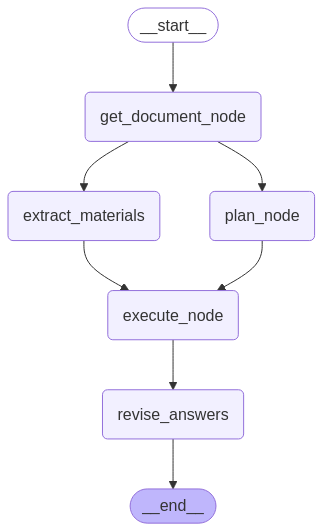

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Run

In [ ]:
final_state = graph.invoke({
    "url":"https://careersatdoordash.com/blog/how-doordash-leverages-llms-for-better-search-retrieval/"}, 
    config={'max_revision': 1, 'on_search': False}
    )

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.09it/s]


##### Plan ######
##### Extract Materials #####
##### Write (execute) #####
--> step:Paragraph 1 - Main Point: DoorDash는 사용자들이 복합적인 요구 사항을 포함한 구체적인 검색어를 자주 사용하므로, 검색 시스템은 새로운 검색어에 잘 일반화될 수 있을 만큼 유연하면서도 검색 결과 품질을 보장하기 위한 특정 규칙을 적용할 수 있어야 합니다. 임베딩 기반 시스템과 같이 문서 유사성에 의존하는 검색 시스템은 사용자 의도와 정확히 일치하지 않는 결과를 반환할 수 있지만, DoorDash는 유연한 하이브리드 시스템이 필요하다고 판단하여 키워드 기반 검색 시스템과 강력한 문서 및 키워드 이해를 결합하여 비건 항목만 검색되도록 하는 등의 규칙을 효과적으로 적용하고 있습니다. 이 글에서는 DoorDash가 대규모 언어 모델(LLM)을 활용하여 검색 시스템을 개선하고 소비자에게 더 정확한 검색 결과를 제공하는 방법에 대해 자세히 설명합니다., Word Count: 250 words
--> 
DoorDash에서는 사용자들이 복합적인 요구 사항을 포함한 구체적인 검색어를 자주 사용합니다. 따라서 검색 시스템은 새로운 검색어에 잘 일반화될 수 있을 만큼 유연하면서도 검색 결과 품질을 보장하기 위한 특정 규칙을 적용할 수 있어야 합니다. 예를 들어, "*비건 치킨 샌드위치*"와 같은 검색어의 경우, 임베딩 기반 시스템과 같이 문서 유사성에 의존하는 검색 시스템은 다음과 같은 문서를 검색할 수 있습니다.

*   비건 샌드위치
*   채식 샌드위치
*   치킨 샌드위치
*   비건 치킨 샌드위치

이러한 키워드에 대해서는 목록의 마지막 세트만이 사용자 의도와 정확히 일치합니다. 그러나 선호도는 속성에 따라 다를 수 있습니다. 예를 들어, 소비자는 모든 비건 샌드위치를 대안으로 고려할 수 있지만 비건이 아닌 치킨 샌드위치는 거부할 수 있습니다. 식이 제한은 종종 단백질 선택과 같은 다른 속성보다 

In [ ]:
final_state

{'url': 'https://careersatdoordash.com/blog/how-doordash-leverages-llms-for-better-search-retrieval/',
 'planning_steps': ['Paragraph 1 - Main Point: DoorDash는 사용자들이 복합적인 요구 사항을 포함한 구체적인 검색어를 자주 사용하므로, 검색 시스템은 새로운 검색어에 잘 일반화될 수 있을 만큼 유연하면서도 검색 결과 품질을 보장하기 위한 특정 규칙을 적용할 수 있어야 합니다. 임베딩 기반 시스템과 같이 문서 유사성에 의존하는 검색 시스템은 사용자 의도와 정확히 일치하지 않는 결과를 반환할 수 있지만, DoorDash는 유연한 하이브리드 시스템이 필요하다고 판단하여 키워드 기반 검색 시스템과 강력한 문서 및 키워드 이해를 결합하여 비건 항목만 검색되도록 하는 등의 규칙을 효과적으로 적용하고 있습니다. 이 글에서는 DoorDash가 대규모 언어 모델(LLM)을 활용하여 검색 시스템을 개선하고 소비자에게 더 정확한 검색 결과를 제공하는 방법에 대해 자세히 설명합니다., Word Count: 250 words',
  'Paragraph 2 - Main Point: 일반적인 검색 엔진은 문서와 검색어에 대한 두 가지 주요 여정으로 나눌 수 있는 여러 단계를 포함합니다. DoorDash에서 문서는 항목 또는 상점/레스토랑을 의미하며, 검색어는 사용자가 검색 창에 입력하는 검색어입니다. 검색어 이해 모듈은 구문 분석, 분할, 주석 추가, 특정 개념 연결, 맞춤법 오류 수정 등의 단계를 포함하며, 문서 측면에서는 검색 인덱스에 수집되기 전에 유용한 정보(메타데이터)로 문서를 주석 처리하고 처리하는 필수 단계가 있습니다. DoorDash의 문서 처리에는 음식 항목과 소매 제품 항목 모두에 대해 구축한 지식 그래프가 부분적으로 사용되며, 이러한 그래프를 통해 다양한 엔티티 간의 관계를 정의하여 문서를 더 잘 이해할 수 있습니다. 따라서 상점과 항목에는 풍부

In [ ]:
with open("final.md", "w+") as f:
    f.write(final_state["final_doc"])

## Send to Notion Database

In [ ]:
from utils.convert import MarkdownToNotionBlocks

blocks = MarkdownToNotionBlocks().convert(final_state["final_doc"])

In [ ]:
block_chunks = [blocks[i*100:(i+1)*100] for i in range(len(blocks)//100 + 1)]

In [ ]:
len(block_chunks)

1

In [ ]:
import os
import json
import requests
from urllib.parse import urlparse

co_labels = {
    "careersatdoordash.com": "DoorDash",
    "www.uber.com": "Uber"
}

block_id = None
for i, chunk in enumerate(block_chunks):
    if i==0:
        data = json.dumps(
            {
                "parent": {"database_id": os.environ.get('NOTION_DATABASE_ID')},
                "properties": {
                    "이름": {"title": [{"text": {"content": final_state['title']}}]},
                    "Co": {"select": {"name": co_labels[urlparse(final_state['url']).netloc]}},
                    "Sprint": {"relation": [{"id": os.environ.get("NOTION_DATABASE_RELATION_ID")}]},
                    "Read": {"checkbox": False},
                    "website": {"url": final_state['url']},
                },
                "children": blocks
            }
        )

        response = requests.post(
            url=f"https://api.notion.com/v1/pages",
            headers={
                "Authorization": f"Bearer {os.environ.get('NOTION_SECRET')}",
                "Content-Type": "application/json",
                "Notion-Version": "2022-06-28",
            },
            data=data
        )
        block_id = json.loads(response.content)['id']
        print(response.status_code)
    else:
        data = json.dumps({'children': chunk})
        response = requests.patch(
            url=f"https://api.notion.com/v1/blocks/{block_id}/children",
            headers={
                "Authorization": f"Bearer {os.environ.get('NOTION_SECRET')}",
                "Content-Type": "application/json",
                "Notion-Version": "2022-06-28",
            },
            data=data
        )
        print(response.status_code)